In [1]:
import os
import h5py
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors
import numpy as np
from iminuit import minuit
from iminuit.cost import LeastSquares
import pandas as pd
from scipy import constants

matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
parent = r'C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_KIDS_CHAR\2o raff\RES_DATA'

In [3]:
data = pd.read_csv(parent+r'\RES1.txt', sep='\t')

In [4]:
def resonance_model(f, pars):
    x = (f-pars[3])/pars[3]
    return 1-(pars[0]/pars[1])*(np.exp(1j*pars[2])/(1+1j*2*x*pars[0]))

polyorder = 2

def model(x, *pars):
    pol = np.polyval(pars[:polyorder+1], x)
    res = resonance_model(x, pars[polyorder+1:])
    return pol*np.abs(res)

def phase(x,*pars):
    pol = np.polyval(pars[:polyorder+1], x)
    res = resonance_model(x, pars[polyorder+1:])
    return np.unwrap(np.angle(1j*res.imag+res.real+pol))

In [12]:
F = data['F']
I = data['I']
Q = data['Q']

In [13]:
F = np.array(F)
C = np.array(Q)+1j*np.array(I)
A = np.abs(C)
P = np.unwrap(np.angle(C))

Text(0, 0.5, '$\\phi$ [rad]')

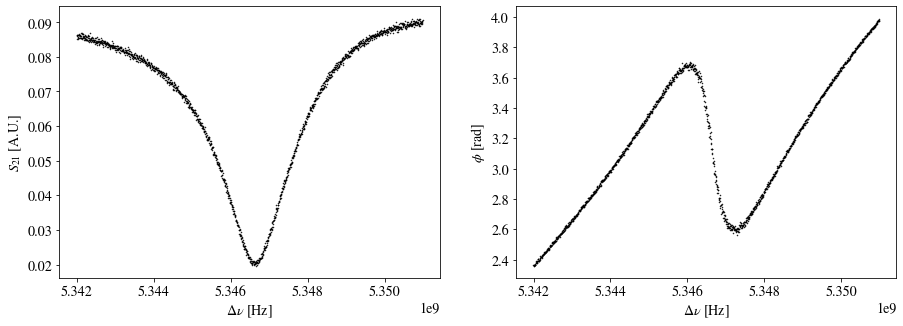

In [14]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].scatter(F,A,s=1,marker='.',color='black')
axs[0].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[0].set_ylabel(r'$S_{21}$ [A.U.]')
axs[1].scatter(F,P,s=1,marker='.',color='black')
axs[1].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[1].set_ylabel(r'$\phi$ [rad]')

In [15]:
A = 20*np.log10(A)
#F = (F - F[np.argmin(A)])/F[np.argmin(A)]
a = np.polyfit(F,P,1)
P = P - np.polyval(a,F)
len_fit = int(np.floor(len(A)/10))
pol_amp = np.polyfit(F[:len_fit], A[:len_fit], 2)
A_rms = np.sqrt(np.mean((np.polyval(pol_amp, F[:len_fit])-A[:len_fit])**2))   

In [16]:
pol_ph = np.polyfit(F[:len_fit], P[:len_fit], 2)
P_rms = np.sqrt(np.mean((np.polyval(pol_ph, F[:len_fit])-P[:len_fit])**2))

In [27]:
p0 = [1e-20,1e-15,-21,4e3,8e3,3.2,5.3467*1e9]

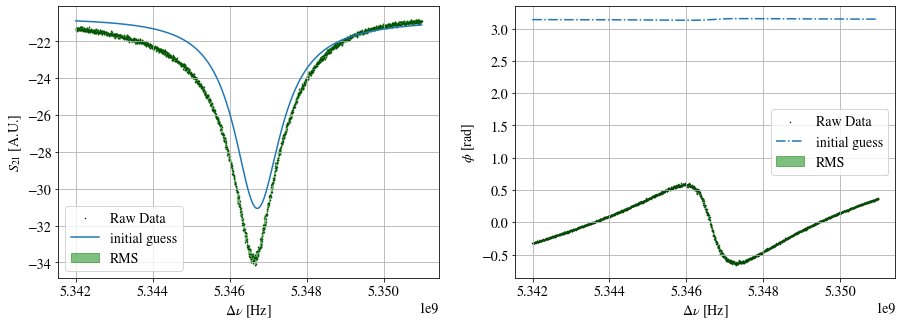

In [28]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].scatter(F,A,s=1,marker='.',color='black', label='Raw Data')
axs[0].plot(F,model(F,*p0), label='initial guess')
axs[0].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[0].set_ylabel(r'$S_{21}$ [A.U.]')
axs[1].scatter(F,P,s=1,marker='.',color='black', label='Raw Data')
axs[1].plot(F,phase(F,*p0),linestyle='-.', label='initial guess')
axs[1].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[1].set_ylabel(r'$\phi$ [rad]')
axs[0].fill_between(F, A+A_rms, A-A_rms, alpha=0.5, color='green',label='RMS')
axs[1].fill_between(F, P+P_rms, P-P_rms, alpha=0.5, color='green',label='RMS')
axs[0].legend()
axs[1].legend()
axs[0].grid()
axs[1].grid()

In [29]:
lsq = LeastSquares(F,A,A_rms*np.ones(len(A)),model)
m= minuit.Minuit(lsq, *p0)
m.migrad(ncall=10000, iterate=1000)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.883e+04 (χ²/ndof = 11.8) │              Nfcn = 237              │
│ EDM = 0.000131 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  9.1e-21  │  1.2e-21  │            │            │         │         │       │
│ 1 │ x1   │ -7.92e-12 │ 0.24e-12  │            │            │         │         │       │
│ 2 │ x2   │  -21.058  │   0.033   │            │            │         │         │       │
│ 3 │ x3   │ 3.7209e3  │ 0.0031e3  │            │            │         │         │       │
│ 4 │ x4   │  6.172e3  │  0.005e3  │            │            │         │         │       │
│ 5 │ x5   │  3.0443   │  0.0006   │            │            │         │         │       │
│ 6 │ x6   │5.3466694e9│0.0000005e9│            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│    │                              x0                              x1                              x2                              x3                              x4                              x5                              x6 │
├────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │                        1.42e-42                  72.9869320e-36     -39.5973599859800415857e-24   -2.0000093758357069262388e-21   -3.6273412998647458493906e-21        533.6715239483211235e-27 -207.6979738368314087892941e-21 │
│ x1 │                  72.9869320e-36                        5.84e-26              -1.99396462715e-15            -332.97235260042e-15            -744.90455324231e-15                  1.81872754e-18            -198.32788633709e-15 │
│ x2 │     -39.5973599859800415857e-24              -1.99396462715e-15                         0.00111                          0.0536                          0.0956                        -15.2e-6                          5.9302 │
│ x3 │   -2.0000093758357069262388e-21            -332.97235260042e-15                          0.0536                            9.86                              14                         28.4e-6                             -45 │
│ x4 │   -3.6273412998647458493906e-21            -744.90455324231e-15                          0.0956                              14                            28.8                         20.6e-6                             -50 │
│ x5 │        533.6715239483211235e-27                  1.81872754e-18                        -15.2e-6                         28.4e-6                         20.6e-6                        3.72e-07                    -221.

In [30]:
lsqp = LeastSquares(F,P,P_rms*np.ones(len(P)),phase)
mp = minuit.Minuit(lsqp, *p0)
mp.migrad(ncall=10000, iterate=1000)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.91e+06 (χ²/ndof = 1198.4)│             Nfcn = 44872             │
│ EDM = 1.21e+12 (Goal: 0.0002)    │           time = 16.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  0.7e-18  │  1.9e-18  │            │            │         │         │       │
│ 1 │ x1   │ 35.8e-12  │  3.2e-12  │            │            │         │         │       │
│ 2 │ x2   │  -20.798  │   0.017   │            │            │         │         │       │
│ 3 │ x3   │ 13.315e3  │  0.017e3  │            │            │         │         │       │
│ 4 │ x4   │  4.93e3   │  0.08e3   │            │            │         │         │       │
│ 5 │ x5   │  3.0698   │  0.0009   │            │            │         │         │       │
│ 6 │ x6   │5.3466427e9│0.0000004e9│            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│    │                      x0                      x1                      x2                      x3                      x4                      x5                      x6 │
├────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │                3.57e-36                -134e-36      -761.867198719e-27    796.314242299101e-24   5.955267110178252e-21      -383.415502022e-27 277.732577522396014e-21 │
│ x1 │                -134e-36                9.91e-24       -12.577943015e-15       750.468293977e-15   -155.572720957176e-12          275.709230e-18   -111.422740294286e-12 │
│ x2 │      -761.867198719e-27       -12.577943015e-15                0.000282                 4.05e-3              -824.98e-3                  1.5e-6              -621.40e-3 │
│ x3 │    796.314242299101e-24       750.468293977e-15                 4.05e-3                     308                      -0                625.6e-6                 -0.24e3 │
│ x4 │   5.955267110178252e-21   -155.572720957176e-12              -824.98e-3                      -0                6.39e+03             -11.5709e-3                     5e3 │
│ x5 │      -383.415502022e-27          275.709230e-18                  1.5e-6                625.6e-6             -11.5709e-3                8.78e-07            -268.6292e-3 │
│ x6 │ 277.732577522396014e-21   -111.422740294286e-12              -621.40e-3                 -0.24e3                     5e3            -268.6292e-3                 1.8e+05 │
└────┴─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

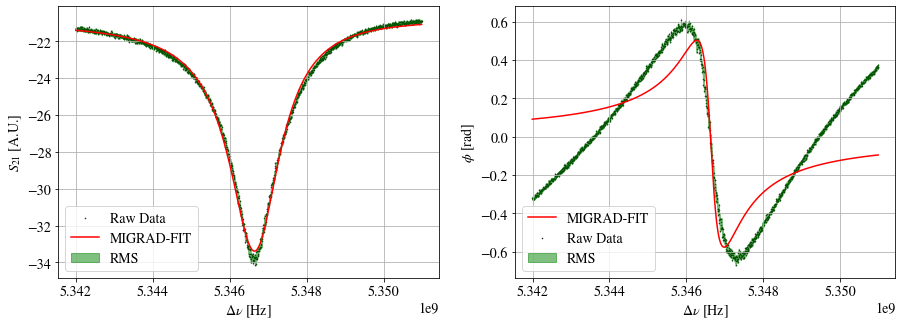

In [31]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].scatter(F,A,s=1,marker='.',color='black', label='Raw Data')
axs[0].plot(F, model(F,*m.values), color='red',label='MIGRAD-FIT')
axs[1].plot(F, phase(F,*mp.values), color='red',label='MIGRAD-FIT')
axs[0].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[0].set_ylabel(r'$S_{21}$ [A.U.]')
axs[1].scatter(F,P,s=1,marker='.',color='black', label='Raw Data')
axs[1].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[1].set_ylabel(r'$\phi$ [rad]')
axs[0].fill_between(F, A+A_rms, A-A_rms, alpha=0.5, color='green',label='RMS')
axs[1].fill_between(F, P+P_rms, P-P_rms, alpha=0.5, color='green',label='RMS')
axs[0].legend()
axs[1].legend()
axs[0].grid()
axs[1].grid()

In [32]:
print('Q(S21) = ', m.values[3])
print('Q(phase) = ', mp.values[3])
print('Q_c(S21) = ', m.values[4])
print('Q_c(phase) = ', mp.values[4])

Q(S21) =  3720.8875453481037
Q(phase) =  13315.153031173191
Q_c(S21) =  6171.746484589482
Q_c(phase) =  4934.087184733525


In [33]:
Qi = (m.values[3]**(-1)+m.values[4]**(-1))**(-1)
print('Qi(S21) = ',Qi)

Qi(S21) =  2321.360980104894


In [57]:
idx = [i for i,x in enumerate(F) if x>5.3463*1e9 and x<5.3469*1e9]
f = F[idx]
a = A[idx]

In [59]:
vals = np.polyfit(f,a,2)

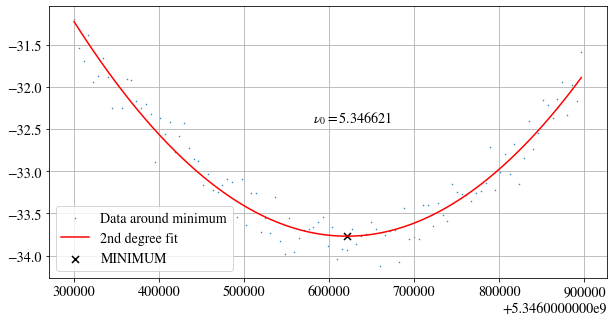

In [79]:
plt.figure(figsize=(10,5))
plt.scatter(f,a,marker='.',s=1, label='Data around minimum')
plt.plot(f,np.polyval(vals,f),color='red',label='2nd degree fit')
plt.scatter(-vals[1]/(2*vals[0]),-(vals[1]**2-4*vals[0]*vals[2])/(4*vals[0]),marker='x',s=50,color='black',label='MINIMUM')
plt.legend()
plt.text(f[50],a[20],r'$\nu_{0} = $'+"{:.6f}".format((-vals[1]/(2*vals[0])*1e-9)))
plt.grid()